In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import numpy as np

training_dataset_path = '/content/drive/MyDrive/datasets/tinyaes/train'

shard_array = []

for shard_path in os.listdir(training_dataset_path):
  shard_array.append(np.load(training_dataset_path + '/' + shard_path))

In [7]:
import random
example_shard_index = random.randint(0,256)

example_shard = shard_array[example_shard_index]
known_key = example_shard['keys'][:,0]
print(f"Known key: {known_key}")

Known key: [ 87 203  71  57  72  34 177  79 105 234 237  48 205 184 241  96]


In [8]:
AES_SBOX = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def process_aes(input_byte, key_byte):
  sbox_input = input_byte ^ key_byte
  return AES_SBOX[sbox_input]

In [ ]:
import matplotlib.pyplot as plt

# Sanity check => sub_bytes_out is already calculated
for pt_idx, plaintext in enumerate(example_shard['pts'].transpose()):
  for byte_idx, pt_byte in enumerate(plaintext):
    assert(process_aes(pt_byte, known_key[byte_idx]) == example_shard['sub_bytes_out'].transpose()[pt_idx][byte_idx])

# Attack a single key byte
plotting_data = []
target_byte = 0
key_guesses = list(range(0, 256))
key_guess_predictions = 256*[0]
# key_guesses = [0x00, 0x01, 0x21, 0xA2, known_key[0]]
for key_guess in key_guesses:
  
  ones  = []
  zeros = []

  for trace_idx, trace in enumerate(example_shard['traces']):

    leak = process_aes(key_guess, example_shard['pts'].transpose()[trace_idx][target_byte])

    # Trial and error => better results with less datapoints per trace (correct key is in the top 10) -> this happened once, not a rule => probably not enough traces per key
    if (leak & (0x01 << 1)):
      ones.append(trace[:, 0])
    else:
      zeros.append(trace[:, 0])


  # print(f"Guess: {hex(key_guess)}")    
  ones_mean = np.asarray(ones).mean(axis=0)
  zeros_mean = np.asarray(zeros).mean(axis=0)
  mean_difference = abs(ones_mean - zeros_mean)

  plotting_data.append(mean_difference)

  # Look for the maximal difference => most possible leakage for this key guess
  key_guess_predictions[key_guess] = np.max(mean_difference)
  
  # print(f"Peak: {key_guess_predictions[key_guess]}")

  # If key is false -> half of the outputs will have 1 as first bit and half will have
  # 0 as first bit -> difference of means will be close to zero, and graph should appear flat
  # If key is correct -> there will be a spike either number of first bit == 0 is greater or number 
  # of first bit == 1 is greater and then the graph will spike in the areas where the target bit is processed

In [9]:
def DPA_selection_function(plaintext_byte, key_guess_byte, target_bit = 0):
  sbox_output = process_aes(plaintext_byte, key_guess_byte)

  if sbox_output & (0x01 << target_bit):
    return 1
  else:
    return 0

Mozda ce drugi bitovi proizvesti bolje rezultate:

In [2]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
from tqdm.auto import tqdm

# Attack a single key byte
plotting_data = []
target_byte = 0
key_guesses = list(range(0, 256))
key_guess_predictions = 256*[0]
key_guess_predictions_loop = []
# key_guesses = [0x00, 0x01, 0x21, 0xA2, known_key[0]]
for key_guess in tqdm(range(0, 256), desc=f"Key guess: {hex(key_guess)}, actual key: {hex(known_key[target_byte])}", position=0):
  
  ones  = []
  zeros = []

  for trace_idx, trace in enumerate(tqdm(example_shard['traces'], desc="Inspecting traces", position=1, leave=False)):

    for tb in range(0,8):
      if(DPA_selection_function(key_guess, example_shard['pts'].transpose()[trace_idx][target_byte], target_bit=tb) == 1):
        ones.append(trace[:10000, 0])
      else:
        zeros.append(trace[:10000, 0])

    ones_mean_loop = np.asarray(ones).mean(axis=0)
    zeros_mean_loop = np.asarray(zeros).mean(axis=0)
    mean_difference_loop = abs(ones_mean_loop - zeros_mean_loop)

    key_guess_predictions_loop.append((key_guess, np.max(mean_difference_loop), tb))

  # print(f"Guess: {hex(key_guess)}")    
  ones_mean = np.asarray(ones).mean(axis=0)
  zeros_mean = np.asarray(zeros).mean(axis=0)
  mean_difference = abs(ones_mean - zeros_mean)

  plotting_data.append(mean_difference)

  # Look for the maximal difference => most possible leakage for this key guess
  key_guess_predictions[key_guess] = np.max(mean_difference)

Key guess: 0x0, actual key: 0x57:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.


Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

In [1]:
for g in key_guess_predictions_loop:
  if g[0] == 87:
    print(g)

NameError: ignored

In [23]:
max_mean_found = 0
max_mean_bit = -1
max_mean_guess = -1

correct_key_max_mean = 0
correct_key_bit = -1

for _guess, _max, _bit in key_guess_predictions_loop:
  if _max > max_mean_found:
    max_mean_found = _max
    max_mean_bit = _bit
    max_mean_guess = _guess

    if _guess == 40 and _max > correct_key_max_mean:
      correct_key_max_mean = _max
      correct_key_bit = _bit

print(f"Most likely across all: keyguess {hex(max_mean_guess)}, mean value: {max_mean_found},target_bit {max_mean_bit} ")
print(f"Most likely for correct key (first byte): {correct_key_max_mean}, {correct_key_bit}")

Most likely across all: keyguess 0x8a, mean value: 0.5966796875,target_bit 7 
Most likely for correct key (first byte): 0, -1


In [ ]:
guess_prediction_indices = np.argsort(key_guess_predictions)[::-1]
print(guess_prediction_indices)
predicted_key_values = np.asarray(key_guesses)[guess_prediction_indices]
print(f"Top 10 predicted key values: {[hex(x) for x in predicted_key_values[:10]]}")
print(f"Most likely key byte max mean: {key_guess_predictions[predicted_key_values[0]]}")
print(f"Correct key byte max mean: {key_guess_predictions[known_key[0]]}")

# Plot mean differences on a single graph => spike is expected for the correct key
plt.figure(figsize=(15, 5))
for data in np.asarray(plotting_data)[guess_prediction_indices]:
  plt.plot(data)

Cak i nakon isprobavanja razlicitih bitova, rezultati nisu nista bolji. Ovo je jedan od nedostataka DPA, odnosno za tacne rezultate je potreban veci broj zabelezenih power traceova (zbog racunanja proseka trace-ova). Jedan korak ka boljem resenju je CPA, ali i taj prisup ima ogranicenja koja ce biti pomenuta u narednom koraku. Kao najbolje resenje, odnosno 'state-of-the-art' koriste se Template attacks. Masinsko ucenje dovodi do poboljsanja u analizi kao sto su:
* manji broj trace-va
* nije potrebno kompleksno preprocesiranje
* nije potrebna duboka ekspertiza
* ...

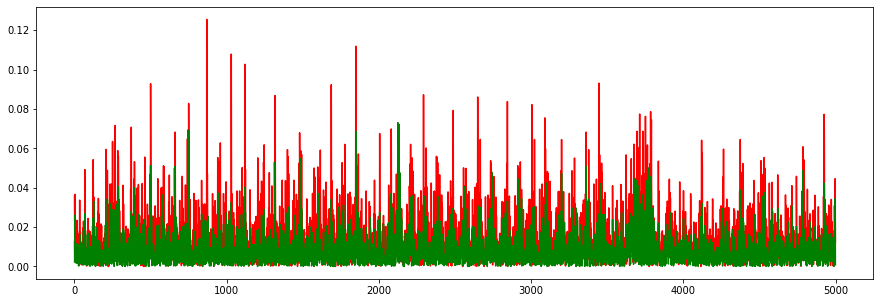

In [20]:
plt.figure(figsize=(15, 5))
plt.title('Mean differences graph')
plt.plot(plotting_data[predicted_key_values[0]], color='r', label='Predicted key')
plt.plot(plotting_data[known_key[0]], 'g', label='Correct key')
plt.legend(loc='best')
plt.show()

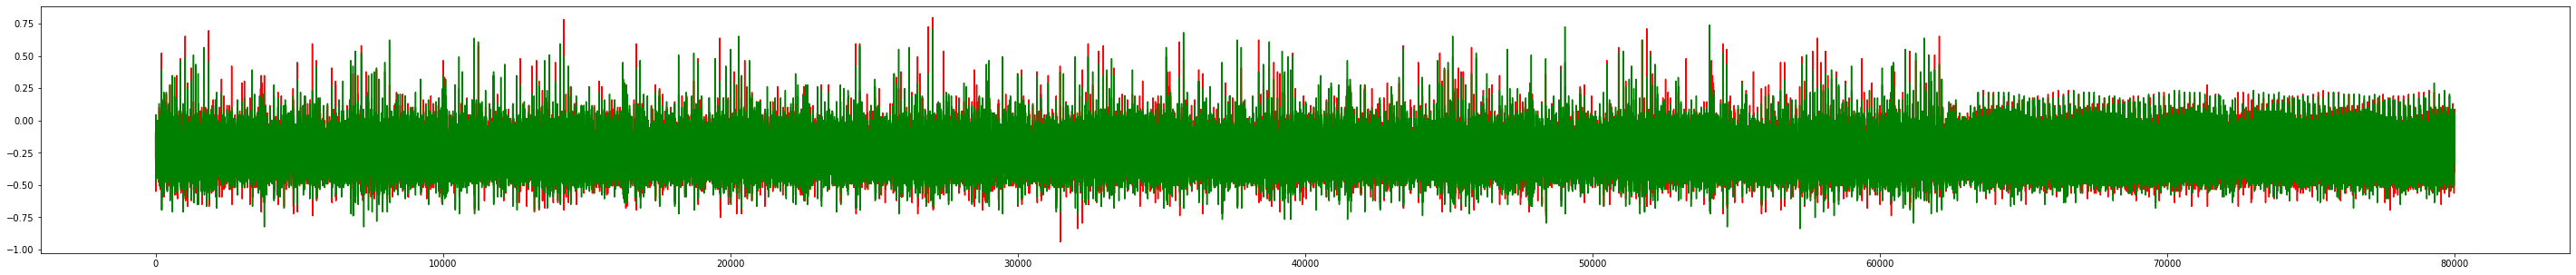

In [10]:
plt.figure(figsize=(50, 5))
plt.plot(example_shard['traces'][predicted_key_values[0]], 'r')
plt.plot(example_shard['traces'][known_key[0]], 'g')

Ocigledno je da dobijeni rezultati nisu jednoznacni i nisu dovoljno precizni. Jedan od razloga za ovo moze biti nedovoljan broj power traceova za jedan kljuc. 